<h2 style="text-align: center; font-weight: bold; font-family: 'Times New Roman', Times, serif;">Clustering Analysis of Breast Cancer Wisconsin Data</h2>
<p style="text-align: center; font-weight: bold; font-family: 'Times New Roman', Times, serif;">Arvin Corotana and Hamza Elshafie</p>

-----

In [3]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from ucimlrepo import fetch_ucirepo

dataf = fetch_ucirepo(id=15)
X = dataf.data.features
y = dataf.data.targets

Look for missing data and quick look at data:

# 1) Data Preproccessing
----

In [4]:
X.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [5]:
X.shape

(699, 9)

array([[<AxesSubplot:title={'center':'Clump_thickness'}>,
        <AxesSubplot:title={'center':'Uniformity_of_cell_size'}>,
        <AxesSubplot:title={'center':'Uniformity_of_cell_shape'}>],
       [<AxesSubplot:title={'center':'Marginal_adhesion'}>,
        <AxesSubplot:title={'center':'Single_epithelial_cell_size'}>,
        <AxesSubplot:title={'center':'Bare_nuclei'}>],
       [<AxesSubplot:title={'center':'Bland_chromatin'}>,
        <AxesSubplot:title={'center':'Normal_nucleoli'}>,
        <AxesSubplot:title={'center':'Mitoses'}>]], dtype=object)

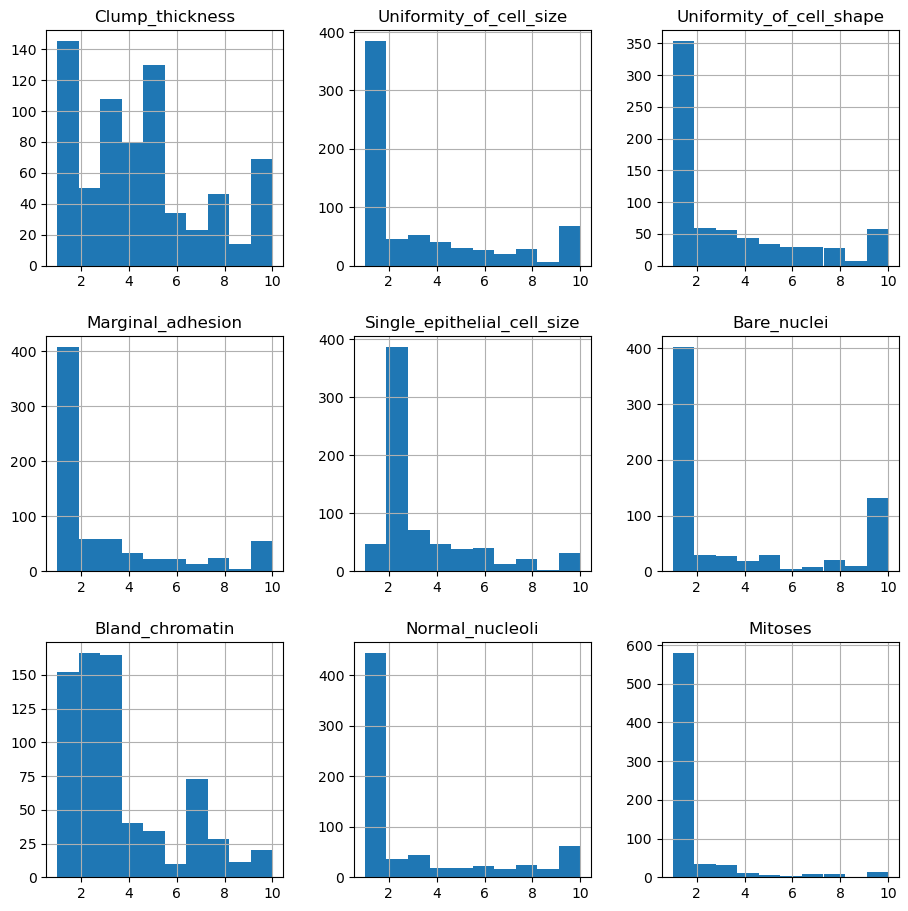

In [6]:
X.iloc[:,:9].hist(figsize=(11,11))

array([[<AxesSubplot:title={'center':'Class'}>]], dtype=object)

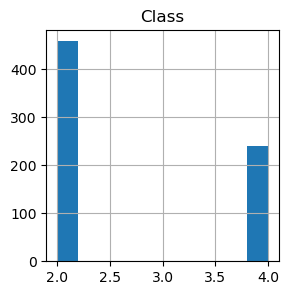

In [7]:
y.iloc[:,:2].hist(figsize=(3,3))

**1.1 Missing Values Imputation**

In [8]:
X.isnull().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

In [9]:
y.isnull().sum()

Class    0
dtype: int64

Imputation using mode

In [10]:
mode_imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(mode_imputer.fit_transform(X), columns=X.columns)

Check that they have all been filled in

In [11]:
nan_count = np.isnan(X_imputed).sum()
print(nan_count)

Clump_thickness                0
Uniformity_of_cell_size        0
Uniformity_of_cell_shape       0
Marginal_adhesion              0
Single_epithelial_cell_size    0
Bare_nuclei                    0
Bland_chromatin                0
Normal_nucleoli                0
Mitoses                        0
dtype: int64


In [12]:
X_imputed.shape

(699, 9)

# 2 Princial Component Analysis
----

**2.1 Standardisation Prior to PCA**

The decision to standardise the data before doing PCA is determined by the measurement scales of the original features. Because PCA produces a feature subspace that maximises variation along the axes, standardising the data makes sense, especially if the features were measured on different scales. Despite the fact that all variables in the breast cancer dataset were assessed on the same scale (1-10), each item reflects a separate element of cell properties and may have different distributions and variances. We therefore apply standard normalisation to guarantee that all features contribute equally to the PCA. This seeks to rescale the features to reflect the parameters of a standard normal distribution with a mean of zero and a standard deviation of one. This is important since PCA operates on the assumption that the data is normally distributed and is highly sensitive to the variance of the features. If we do not normalise the data, features with wide range differences will outweigh those with modest ranges, potentially leading to misleading results [1].

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=0)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**2.2 The Process of PCA**

The process of Principal Component Analysis (PCA) can be summarised through four main steps. Initially, we compute the **mean vector**, which in our case is 9-dimensional, representing each of the individual raw features in our dataset. The mean vector $\boldsymbol{\vec{x}}$ is calculated using the formula:

\begin{equation}
\boldsymbol{\vec{x}} = \frac{1}{N} \sum_{i=1}^{N} \boldsymbol{\vec{x}}^{(i)}
\end{equation}

Here, $N$ represents the number of observations, and $\boldsymbol{\vec{x}}^{(i)}$ signifies each datum.

The purpose of this step is to centralise the data by subtracting the mean vector from each data point. This subtraction corresponds to an overall translation in the space where the data lives and carries no information about the actual relationships between the variables [2]. Note that in our situation, this phase will not result in any data shift because we had standardised the data in the previous stage to have a mean of 0 and variance of 1, but we still include it because it is part of the PCA process and may be useful if we decide not to standardise the data.

<div style="text-align: center;">
<img src="Figures/Standard Normalisation.jpg" alt="Alternative text" width="700" height="250" />
</div>

Next step is then to calculate the **covariance matrix** of the whole dataset which is given by:

\begin{equation} 
\mathbf{\Sigma} = \frac{1}{N-1} \sum_{i=1}^{N} (\boldsymbol{\vec{x}}^{(i)} - \boldsymbol{\bar{x}})^T \cdot (\boldsymbol{\vec{x}}^{(i)} - \boldsymbol{\bar{x}})
\end{equation}


Note that in our convention $\boldsymbol{\vec{x}}^{(i)}$ and $\boldsymbol{\bar{x}}$ are row vectors. The equation above is therefore the sum of the dot products of 9D column vectors and 9D row vectors. This makes $\mathbf{\Sigma}$ a 9 × 9 square matrix.

Then, using the **scipy.linalg.eigh** function, we calculate the eigenvalues and eigenvectors of $\mathbf{\Sigma}$, that is we wish to compute the unit vectors $\boldsymbol{\vec{v}}$ that obey:

\begin{equation}
\mathbf{\Sigma} \boldsymbol{\vec{v}} = \lambda \boldsymbol{\vec{v}}
\end{equation}

where $\lambda$ represents the eigenvalue corresponding to the eigenvector $\boldsymbol{\vec{v}}$. The eigenvalues are derived from the matrix's characteristic polynomial, which is expressed as:

\begin{equation}
\text{det}(\mathbf{\Sigma} - \lambda \mathbf{I}) = 0
\end{equation}

By substituting each eigenvalue $\lambda$ into the equation and solving for $\boldsymbol{\vec{v}}$, one may then obtain the corresponding eigenvector for each eigenvalue. With nine raw features in our dataset, we expect to extract nine related eigenpairs. The eigenvectors calculated are the components. To choose the first principal component we simply look for the eigenpair with the largest eigenvalue. If we do this iteratively and sort the eigenpairs by eigenvalues, we then have a ranking of importance of all of our new components [2].

**2.3 The PCA Class**

In [15]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pandas as pd

class PCA:
    """
    Principal Component Analysis (PCA) Class

    Attributes
    ----------
    n_components : int
        Number of principal components to retain.
    feature_names : list
        Names of the raw features in the dataset.
    components : numpy.ndarray
        Principal components (eigenvectors of the covariance matrix).
    mean_vector : numpy.ndarray
        Mean of the features.
    explained_variance_ : np.ndarray
        Variance explained by each of the selected components.
    explained_variance_ratio_ : numpy.ndarray
        Percentage of variance explained by each of the selected components.

    References
    ----------
    * MLiS Notes: Garrahan JP, Gillman E, Mair JF. 2023. Machine Learning in Science Part 1 (PHYS4035) Lecture Notes.
    * Github: https://github.com/erdogant/pca
    * Textbook: Springer Series in Statistics 2002. Choosing a Subset of Principal Components or Variables. In:
    Principal Component Analysis. Springer, New York, NY. https://doi.org/10.1007/0-387-22440-8_6
    """

    def __init__(self, n_components):
        """
        Initialise the PCA object with the number of components desired to retain.

        Parameters
        ----------
        n_components : int
            Number of principal components to retain.
        """
        self.feature_names = []
        self.n_components = n_components
        self.components = None
        self.mean_vector = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """
        Fit the PCA model to the data

        The function computes the principal components of the provided design matrix. The function is normally fitted to
        the training set after splitting. It computes the mean vector, covariance matrix,eigenvalues, and eigenvectors
        of the covariance matrix. The components (eigenvectors) are then arranged in descending order by their associated
        eigenvalues. Only the top ``n_components`` principal components are kept if ``n_components`` is specified.

        Parameters
        ----------
        X : DataFrame
            The design matrix with the features.  Each column represents a feature, and each row represents a sample.

        Notes
        -----
        The method assumes that the input data 'X' is a pandas DataFrame with numerical values. Before using this
        method, missing values in 'X' should be addressed. The method centers the data by subtracting the mean vector
        from each sample but does not scale the features. Therefore, it's advisable to standardise the data before
        performing PCA if the features are on different scales.

        Examples
        -----
        >>> import pandas as pd
        >>> # Load example data
        >>> from sklearn.datasets import load_iris
        >>> data = load_iris()
        >>> X = pd.DataFrame(data.data, columns=data.feature_names)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X)
        """
        self.mean_vector = np.mean(X, axis=0)
        X = X - self.mean_vector

        covariance_matrix = np.cov(X, rowvar=False)
        eigenvalues, eigenvectors = eigh(covariance_matrix)
        pos = np.argsort(eigenvalues)[::-1]

        eigenvalues = eigenvalues[pos]
        eigenvectors = eigenvectors[:, pos]

        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors

        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio()

        # Initialise feature names list
        self.feature_names = X.columns.tolist()

    def transform(self, X):
        """
        Transform the data to the new principal components space.

        The function projects the data onto the principal components computed in the ``fit`` method. This transformation
        is achieved by centering the data again using the mean vector computed in ``fit`` and then multiplying it by the
        principal component vectors. The ``fit`` method must be called before using this method.

        Parameters
        ----------
        X : DataFrame
            The data to be transformed. It must have the same number of features as the dataset used in the ``fit``
            method.

        Returns
        -------
        numpy.ndarray
            The transformed data array, where each row is the projection of the corresponding sample onto the
            principal components.

        Notes
        -----
        This method does not check for missing values in ``X``. It is the responsibility of the user to ensure that ``X``
        is preprocessed appropriately before using this function. To appropriately apply PCA, the 'fit' method should
        be called on the training data to fit the model appropriately and then this function can be used for the
        transformation. It is crucial that the test data, however, is transformed directly using the previously fitted
        model and not fit a new model to prevent data leakage.

        Examples
        -----
        >>> import pandas as pd
        >>> # Load example data
        >>> from sklearn.datasets import load_iris
        >>> data = load_iris()
        >>> X = pd.DataFrame(data.data, columns=data.feature_names)
        >>> y = data.target
        >>> from sklearn.model_selection import train_test_split
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X_train)
        >>> X_train_transformed = pca.transform(X_train)
        >>> X_test_transformed = pca.transform(X_test)
        """

        X = X - self.mean_vector
        return np.dot(X, self.components)

    def explained_variance_ratio(self):
        """
        Calculate and store the explained variance ratio of each principal component.

        The method computes the ratio of variance that each principal component accounts for. It explains
        how much of the total variance in the data is explained by each principal component. The variance ratio
        is calculated as the variance explained by each principal component, ```self.explained_variance``` divided
        by the total variance explained by all the principal components specified by the user. The method then
        updates the ``explained_variance_ratio_`` attribute of the PCA object.

        Notes
        -----
        The 'explained_variance_ratio_' attribute will be a numpy array with the ratio of the variance explained by
        each principal component. These values are useful in understanding the contribution of each principal component
        to the total variance in the dataset, which can help us in making an informed decision on how many principal
        components to retain.
        """

        variance_sum = sum(self.explained_variance_)
        self.explained_variance_ratio_ = self.explained_variance_ / variance_sum

    def plot_explained_variance(self, threshold_criteria, figsize=(6,6)):
        """
        Plot the cumulative explained variance against the number of principal components specified.

        This function plots how much variance is explained by the principal components only specified in
        ```self.n_components```. It plots one line for the cumulative explained variance ratio among all the components
        and plots a bar chart, where the height of each bar corresponds to the variance ratio explained by each
        principal component. Furthermore, the function creates a horizontal and perpendicular line at a defined
        cumulative variance threshold., helping to determine an appropriate number of principal components to retain.

        Parameters
        ----------
        threshold_criteria : float
            Desired threshold for the cumulative explained variance.
        figsize : tuple, optional
            Size of the matplotlib figure. Defaults to (6, 6).

        Raises
        ------
        ValueError
            If the PCA model has not been fitted before calling this method.

        Examples
        -----
        >>> import pandas as pd
        >>> # Load example data
        >>> from sklearn.datasets import load_iris
        >>> data = load_iris()
        >>> X = pd.DataFrame(data.data, columns=data.feature_names)
        >>> y = data.target
        >>> from sklearn.model_selection import train_test_split
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X_train)
        >>> pca.plot_explained_variance(threshold_criteria=0.8, figsize=(9, 3.5))
        """

        if self.explained_variance_ is None or self.explained_variance_ratio_ is None:
            raise ValueError("The PCA model must be fitted before plotting the explained variance.")

        cumulative_explained_variance = np.cumsum(self.explained_variance_ratio_)
        components_required = np.argmax(cumulative_explained_variance >= threshold_criteria) + 1

        # Prepare the figure
        xtick_idx = np.arange(1, len(self.explained_variance_) + 1)
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(xtick_idx, cumulative_explained_variance[:self.n_components], 'o-', color='#0BEF2E', linewidth=1, label='Cumulative explained variance')
        ax.set_xticks(xtick_idx)
        ax.bar(xtick_idx, self.explained_variance_ratio_[:self.n_components], color='#3182bd', alpha=0.8, label='Individual explained variance')

        ax.axhline(y=threshold_criteria, color='red', linestyle='-', linewidth=0.5)
        ax.axvline(x=components_required, color='red', linestyle='-', linewidth=0.5)

        ax.set_ylabel('Explained Variance Ratio', color='black')
        ax.set_xlabel('Principal Component', color='black')
        ax.set_ylim([0, 1.05])
        ax.set_xlim([0, self.n_components + 1])

        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

        title = f'{components_required} Principal Components Explain {cumulative_explained_variance[components_required - 1]:.2%} of the Variance Relative to the Chosen Components'
        ax.set_title(title)
        ax.set_facecolor("white")
        ax.grid(True, color='#A9A9A9', linewidth=0.5)
        ax.legend(loc='best')
        plt.show()


    def get_loadings(self, PC=(0,1)):
        """
        Gets the loadings for specified principal components.

        Loadings are the coefficients of the linear combination of the original raw variables from which the principal
        components are constructed. This method returns the loadings for the specified principal components.

        Parameters
        ----------
        PC : tuple, optional
            Indices of the principal components for which loadings are to be retrieved. The indices are start from zero not one.
            Defaults are set to (0, 1), i.e. the first two components.

        Returns
        -------
        pd.DataFrame
            A DataFrame where each column corresponds to a principal component and the rows are indexed by the original
            feature names.

        Raises
        ------
        ValueError
            If the PCA model has not been fitted before calling this method or if the specified principal component
            indices are invalid (outside the range of computed components).

        Examples
        --------
        >>> import pandas as pd
        >>> from sklearn.datasets import load_iris
        >>> iris = load_iris()
        >>> X = pd.DataFrame(iris.data, columns=iris.feature_names)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X)
        >>> print(pca.get_loadings())
        """

        if self.components is None:
            raise ValueError("The PCA model must be fitted before retrieving loadings.")

        for component in PC:
            if component < 0 or component >= self.n_components:
                raise ValueError(f"Invalid component: {component + 1} ({component}). Components must be between 1 and {self.n_components} (0,{self.n_components-1})")

        component_names = [f'PC{component+1}' for component in PC]
        loadings = pd.DataFrame(self.components[:, PC], columns=component_names, index=self.feature_names)

        return loadings

    def get_projected_data(self, X, PC=(0,1)):
        """
        Gets the projected data onto the specified principal components.

        This function projects the data ``X`` onto the specified principal components and creates a DataFrame where the
        columns represent the principal components and the rows contain the axis of each projected sample in ``X``.

        Parameters
        ----------
        X : DataFrame
            The data to be projected. Should have the same P (features) dimensions of the data used in the ``fit`` function.
        PC : tuple, optional
            Indices of the principal components to project the data onto. The indices are start from zero not one.
            Defaults are set to (0, 1), i.e. the first two components.

        Returns
        -------
        pd.DataFrame
            A DataFrame containin the projected data.

        Raises
        ------
        ValueError
            If the PCA model has not been fitted before calling this method or if the specified principal component
            indices are invalid (outside the range of computed components).

        Examples
        --------
        >>> import pandas as pd
        >>> from sklearn.datasets import load_iris
        >>> iris = load_iris()
        >>> X = pd.DataFrame(iris.data, columns=iris.feature_names)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X)
        >>> print(pca.get_projected_data(X))
        """
        if self.components is None:
            raise ValueError("The PCA model must be fitted before retrieving projected data.")

        for component in PC:
            if component < 0 or component >= self.n_components:
                raise ValueError(f"Invalid component: {component + 1} ({component}). Components must be between 1 and {self.n_components} (0,{self.n_components-1})")

        # Projecting X
        projected_data = self.transform(X)
        component_names = [f'PC{component+1}' for component in PC]
        projected_data_df = pd.DataFrame(projected_data[:, PC], columns=component_names)

        return projected_data_df

    def biplot_2D(self, X, y, PC=(0,1), figsize=(9,5)):
        """
        Generates a 2D biplot of the projected data.

        This method creates a 2D biplot that displays the projection of the original data ``X`` onto the specified
        principal components and the vector loadings of each feature on these components.

        Parameters
        ----------
        X : pd.DataFrame or np.ndarray
            The data to be visualised. Should have the same P (features) dimensions of the data used in the ``fit`` function.
        y : pd.Series or np.ndarray
            The target vector with the corresponding target of each sample in ``X``. The target labels is used for color
             coding the observations in the plot.
        PC : tuple, optional
            Indices of the two principal components to plot against each other in the plot. Defaults to (0, 1).
        figsize : tuple, optional
            Size of the figure. Defaults to (9, 5).

        Returns
        -------
        None
            Does not return a value but shows the biplot.

        Raises
        ------
        ValueError
            If the PCA model has not been fitted before calling this method or if the specified component indices are
            invalid (outside the range of computed components).

        Examples
        --------
        >>> import pandas as pd
        >>> # Load example data
        >>> from sklearn.datasets import load_iris
        >>> data = load_iris()
        >>> X = pd.DataFrame(data.data, columns=data.feature_names)
        >>> y = data.target
        >>> from sklearn.model_selection import train_test_split
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X_train)
        >>> pca.biplot_2D(X_train, y_train)
        """

        if self.components is None:
            raise ValueError("The PCA model must be fitted before creating the biplot.")

        for component in PC:
            if component < 0 or component >= self.n_components:
                raise ValueError(f"Invalid component: {component + 1} ({component}). Components must be between 1 and {self.n_components} (0,{self.n_components-1})")

        projected_data_df = self.get_projected_data(X)
        loadings = self.get_loadings(PC)

        # Scaling the PCs
        scales = [1.0 / (projected_data_df[col].max() - projected_data_df[col].min()) for col in projected_data_df.columns]

        # Prepare Plot
        fig, ax = plt.subplots(figsize=figsize)
        for i, feature in enumerate(self.feature_names):
            ax.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], fc='red', ec='red', head_width=0.005, head_length=0.01, width=0.000005)
            ax.text(loadings.iloc[i, 0] * 1.05, loadings.iloc[i, 1] * 1.05, feature, fontsize=11)

        target_colors = np.where(y == 2, 2, 4)
        scatter = ax.scatter(projected_data_df.iloc[:,0] * scales[0],
                             projected_data_df.iloc[:, 1] * scales[1],
                             c=target_colors,
                             cmap='viridis')

        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

        ax.set_xlabel(f'PC{PC[0]+1}', fontsize=15)
        ax.set_ylabel(f'PC{PC[1]+1}', fontsize=15)
        ax.set_title('Biplot', fontsize=15)
        ax.set_facecolor("white")
        ax.legend(*scatter.legend_elements(), loc="lower left", title="Groups")
        plt.show()

    def biplot_3D(self, X, y, PC=(0,1,2), width=700, height=600):
        """
        Generates a 3D interactive biplot of the projected data.

        This method creates a 3D interactive biplot that displays the projection of the original data ``X`` onto the specified
        principal components and the vector loadings of each feature on these components.

        Parameters
        ----------
        X : pd.DataFrame or np.ndarray
            The data to be visualised. Should have the same P (features) dimensions of the data used in the ``fit`` function.
        y : pd.Series or np.ndarray
            The target vector with the corresponding target of each sample in ``X``. The target labels is used for color
             coding the observations in the plot.
        PC : tuple, optional
            Indices of the three principal components to plot against each other in the plot. Defaults to (0, 1,2). i.e
            first three components.
        width : int, optional
            Width of the plot.
        height : int, optional
            Height of the plot.

        Returns
        -------
        None
            Does not return a value but displays the biplot.

        Raises
        ------
        ValueError
            If the PCA model has not been fitted before calling this method or if the specified component indices are
            invalid (outside the range of computed components).

        Examples
        --------
        >>> import pandas as pd
        >>> # Load example data
        >>> from sklearn.datasets import load_iris
        >>> data = load_iris()
        >>> X = pd.DataFrame(data.data, columns=data.feature_names)
        >>> y = data.target
        >>> from sklearn.model_selection import train_test_split
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        >>> pca = PCA(n_components=3)
        >>> pca.fit(X_train)
        >>> pca.biplot_3D(X_train, y_train, PC=(0,1,2), width=1200, height=700)
        """
        if self.components is None:
            raise ValueError("The PCA model must be fitted before creating the biplot.")

        for component in PC:
            if component < 0 or component >= self.n_components:
                raise ValueError(f"Invalid component: {component + 1} ({component}). Components must be between 1 and {self.n_components} (0,{self.n_components-1})")

        projected_data_df = self.get_projected_data(X, PC)
        loadings = self.get_loadings(PC)

        # Scaling the PCs
        scales = [1.0 / (projected_data_df[col].max() - projected_data_df[col].min()) for col in projected_data_df.columns]

        y_values = y['Class'].values
        target_colors = np.where(y_values == 2, 2, 4)
        trace = go.Scatter3d(
            x=projected_data_df.iloc[:, 0] * scales[0],
            y=projected_data_df.iloc[:, 1] * scales[1],
            z=projected_data_df.iloc[:, 2] * scales[2],
            mode='markers',
            marker=dict(
                size=5,
                color=target_colors,
                opacity=0.8
            )
        )
        arrows = []
        texts = []
        for i, feature in enumerate(self.feature_names):
            arrows.append(
                go.Scatter3d(x=[0, loadings.iloc[i, 0]], y=[0, loadings.iloc[i, 1]], z=[0, loadings.iloc[i, 2]],
                    mode='lines',
                    line=dict(color='red'),
                )
            )
            texts.append(
                go.Scatter3d(x=[loadings.iloc[i, 0]*1.1], y=[loadings.iloc[i, 1]*1.1], z=[loadings.iloc[i, 2]*1.1],
                             mode='text',
                             text=[feature],
                             textfont=dict(color="black", size=10)
                )
            )
        data = [trace] + arrows + texts
        layout = go.Layout(
            title='3D Biplot',
            width=width,
            height=height,
            scene=dict(
                xaxis=dict(title=f'PC{PC[0]+1}'),
                yaxis=dict(title=f'PC{PC[1]+1}'),
                zaxis=dict(title=f'PC{PC[2]+1}')
            )
        )
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)

In [16]:
pca = PCA(n_components=9)
pca.fit(X_train)

**2.4 Explained Variance Plot**

To see how much each component contributes to explaining the data's variation. We use the **plot_explained_variance** function in our PCA implementation. First the plot displays a bar chart, where the height of each bar corresponds to the variance ratio explained by each principal component relative to the chosen number of components when fitting the model. This helps us understand the significance of each component independently. The function additionally superimposes a line plot showing the cumulative explained variance ratio, which accumulates the variance explained as we move from the first to the last component. Furthermore, the function creates a horizontal line at a defined cumulative variance threshold.

We utilise two plots and set the desired thresholds at 80% and 90% to evaluate how many components are required to explain 80% and 90% of the variation in the data, respectively. The purpose of this stage is to determine whether we can retain a small enough subset of the components, that we can project and visualise the data while maintaining the majority of the information described in the dataset. The first figure demonstrates that we can retrain three PCs while retaining 82.54% of the data's variance and five PCs to retain 90.98%. Moving on, we will maintain only three PCs for visualisation reasons and since 82.54% seems like a reasonable cutt-off to explain most of the information in the data [3].

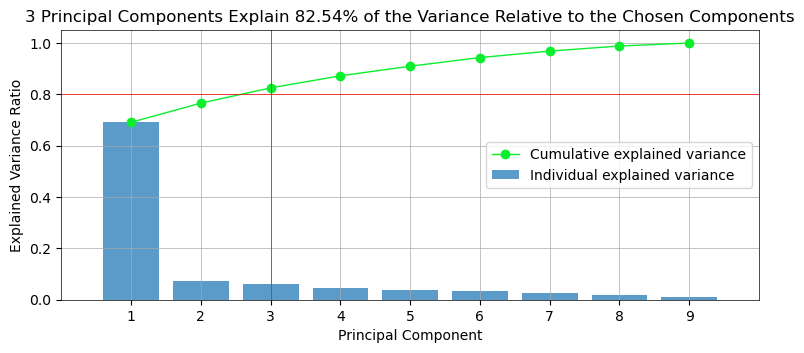

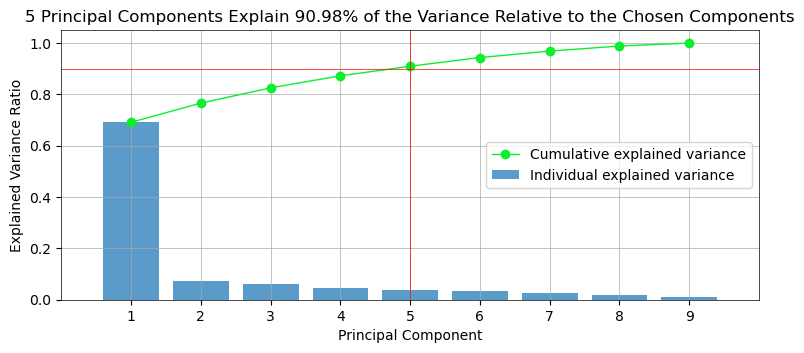

In [17]:
pca.plot_explained_variance(threshold_criteria=0.8, figsize=(9,3.5))
pca.plot_explained_variance(threshold_criteria=0.90, figsize=(9,3.5))

**2.5 Biplot**

To visualise the data, we use the **biplot_2D** function to plot pairwise biplots between the PCs. We generate three graphs to show PC1 vs PC2, PC1 vs PC3, and PC2 vs PC3. In each plot, the principal components are presented as the new axis for the data , and each data point in the plot represents an observation (data point) in the transformed principal component space. Furthermore, because we want to observe how each raw feature contributes to the principal components, we generate vectors reflecting the PCA loadings for each variable. The direction and length of the vectors demonstrate how each feature contributes to the components.  We can also gain insight into the relationships between the raw features as a result of this.  Features with vectors heading in the same direction are positively associated, and vice versa. In the context of tumour analysis, this might suggest that particular features tend to rise together in either benign or malignant tumours. Finally, we examine if the data on the new axis contains any clusters, which quite clearly it does.

In [18]:
pca = PCA(n_components=3)
pca.fit(X_train)
print(f"*********** Loadings (weights) of the original variables to the principal components ***********\n{pca.get_loadings((0,1))}")

*********** Loadings (weights) of the original variables to the principal components ***********
                                  PC1       PC2
Clump_thickness             -0.290210  0.014053
Uniformity_of_cell_size     -0.408848 -0.237363
Uniformity_of_cell_shape    -0.393857 -0.181180
Marginal_adhesion           -0.344925  0.103669
Single_epithelial_cell_size -0.246809 -0.174070
Bare_nuclei                 -0.425428  0.821127
Bland_chromatin             -0.291394 -0.028453
Normal_nucleoli             -0.364718 -0.419087
Mitoses                     -0.121209 -0.137456


In [19]:
print(f"*********** Projected Data on The New Axis ***********\n{pca.get_projected_data(X, (0,1)).head(6)}")

*********** Projected Data on The New Axis ***********
         PC1       PC2
0   4.408646 -0.144531
1  -4.806783  5.115222
2   4.563638  0.648490
3  -5.211899 -3.285489
4   4.009006  0.048754
5 -15.100372  0.690977


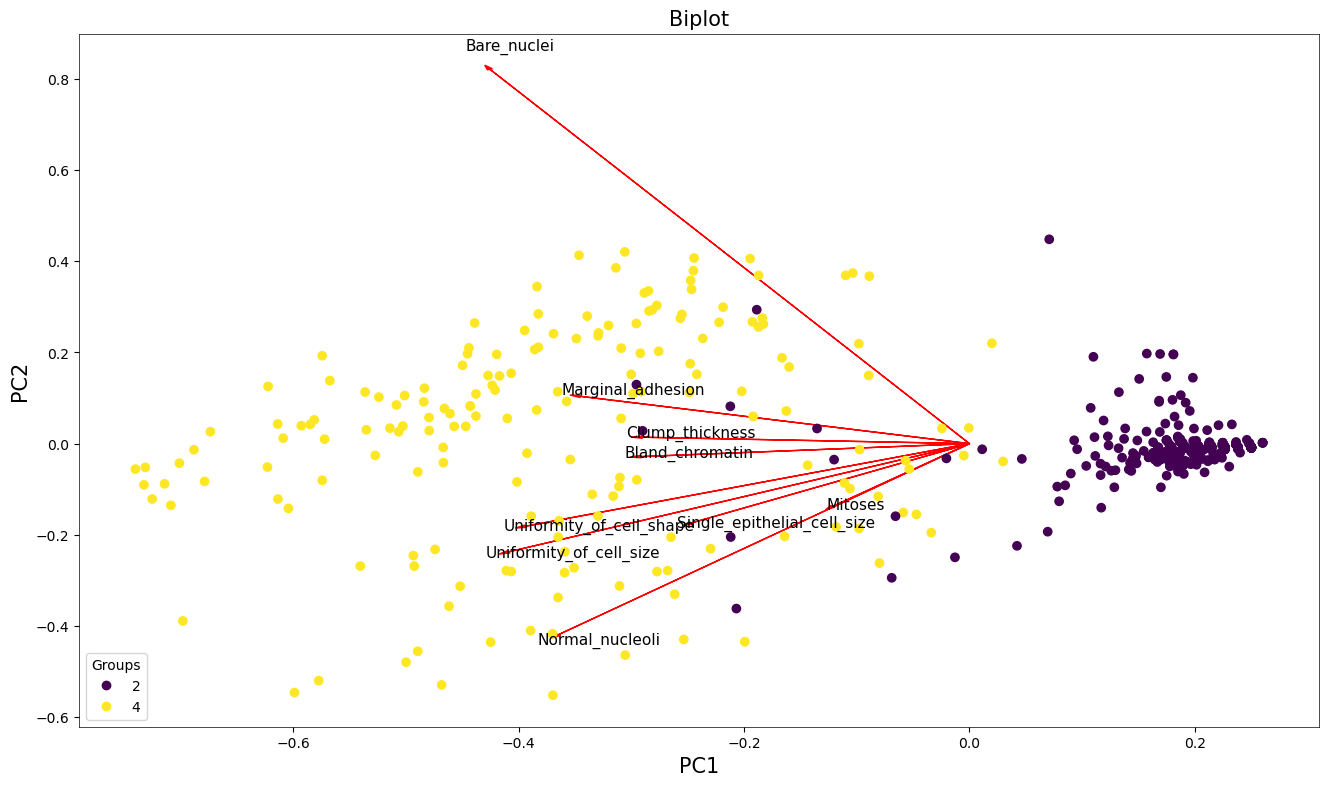

In [20]:
pca.biplot_2D(X_train, y_train, PC=(0,1), figsize=(16,9))

**PC1 vs PC2**

The first thing we observe in the data is that there are two distinct clusters: the purple points indicate the benign tumours, labelled as 2, and the yellow points represent the malignant tumours, labelled as 4. On the plot, the yellow cluster is on the left side, while the purple cluster is on the right. In section 2.2, we stated that by iteratively sorting the eigenpairs by eigenvalues, we would then have a ranking of importance for each of our new components. Based on this, we can see that the variance is maximised along PC1, while the component along PC2 still explains the variance in the data, although less PC1.

Analysing the contribution of the raw features to the components, we can observe that they are all negatively correlated with PC1, pointing all the way to the left (the direction of malignant tumours). The length and direction of the vectors, however, differ. For instance, **Bare_nuclei**, which has the longest vector, points strongly negative towards PC1 but appears to have a positive correlation with PC2. This suggests that as **Bare_nuclei** values increase, the data points fall more towards PC1's left side, which is associated with malignant tumours. Overall, this feature can be very helpful in differentiating between the two tumour variants. Next, **marginal_adhesion**, shares the same correlations with the axis as the Bare_nuclei, but its vector is much shorter, and so is less able to discriminate between the two components, though it is still moderately long enough to be considered a factor in tumour type differentiation. **Bland_chromatin** and **Clump_thickness** vectors are closely aligned with one another and nearly entirely uncorrelated with PC2. Because they are among the shortest of all the vectors, they may not be particularly significant in distinguishing between the tumours.

Both the **Uniformity_of_cell_shape** and **Uniformity_of_cell_size** vectors are very similar; they have negative correlations with PC1 and PC2, and their length suggests that they may account for a sizable portion of PC1's variance, indicating that they are important characteristics in the distinction between benign and malignant tumours. With a somewhat short vector heading to the left, **Single_epithlial_cell_size** indicates a moderately negative connection with PC1 and PC2. On the other hand, **Normal_nucleoli** has a long vector that is pointing towards the left of PC1, but more significantly downwards on PC2 indicating a strong negative correlation with PC2. Finally, **Mitoses** has a short vector pointing slightly downwards to the left of PC1, suggesting that this feature has small influence on both PC1 and PC2, implying it's less critical in distinguishing between the two types of tumors.


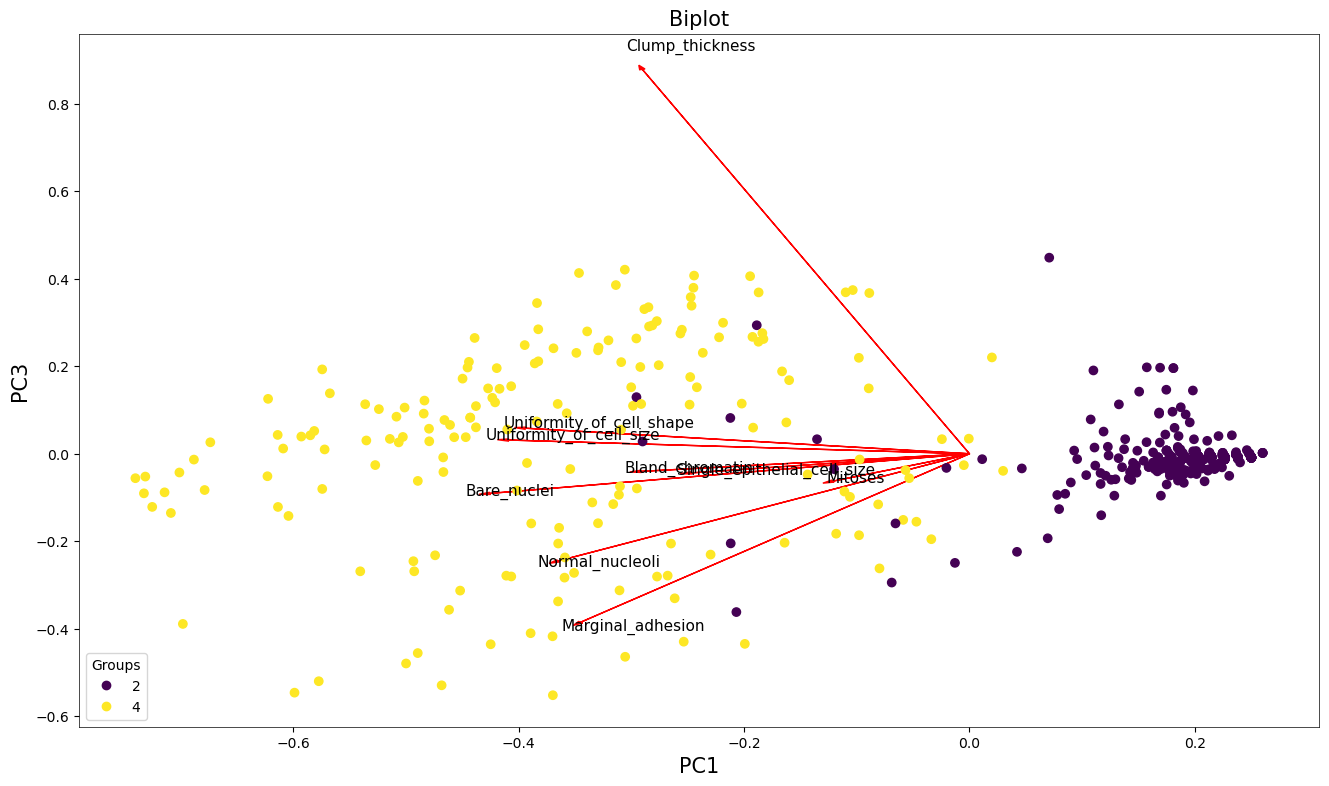

In [21]:
pca.biplot_2D(X_train, y_train, PC=(0,2), figsize=(16,9))

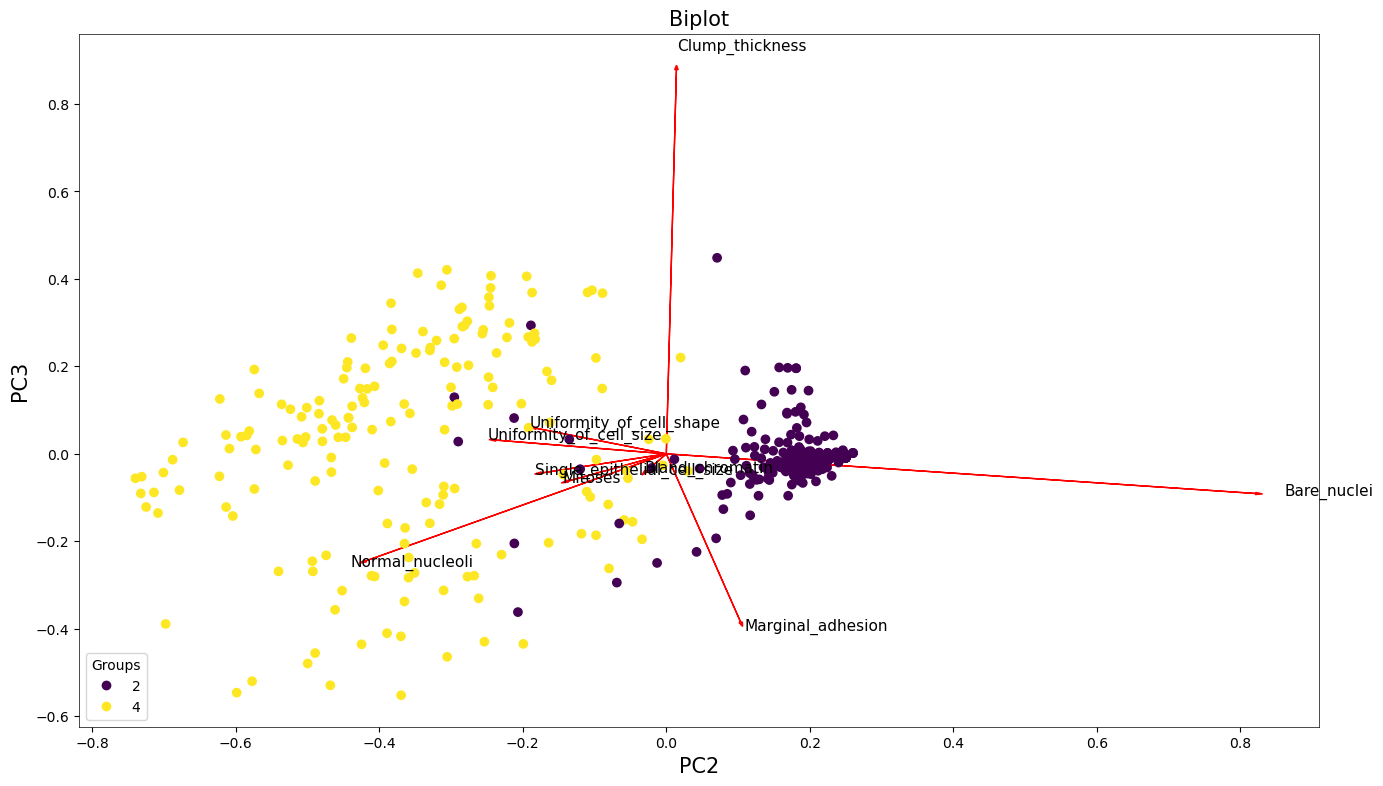

In [22]:
pca.biplot_2D(X_train, y_train, PC=(1,2), figsize=(16,9))

**2.6 3D Biplot**

In [23]:
pca.biplot_3D(X_train, y_train, PC=(0,1,2), width=1200, height=700)

# Cluster Analysis
----

**3.1 K-means Class**

K-means is an unsupervised learning model that aims to find the best centroids (central aspect of a cluster) to characterise the clusters so that the groups can be characterised in space as data points are assigned to clusters.

The parameter k specificies how many centroids/clusters should be assigned and used in the calculations for optimal centroids and datapoint assignment. A k of 1 would encompass all datapoints with a centroid in the middle of the circular space that covers all data. The model can be altered through k as an assigment of 2 would attempt to assign datapoints to one of the 2 centroids where the squared distance between datapoints and centroid is at the minimum possible [4]. 

INSERT SMALLEST SQUARED DISTANCE EQUATION

The model usually begins with a random assignement in the feature space with all datapoints assigned to the closest centroid. The mean position in space for all of the assigned datapoints to the centroid is calculated to be the new centroid [2]. 

INSERT EQUATION FOR THE MEAN POSITION OF CLUSTER

All datapoints are again assigned to the nearest centroid. The mean of the datapoints is again calculated and assigned and the new centroid with new assignements of datapoints to the centroids. This is repeated until convergence resulting in the optimal position of centroids were the distance between the centroids and the assigned datapoints within its circular boundary.


In [66]:
import numpy as np
import matplotlib.pyplot as plt

class KMeansClustering:
    def __init__(self, k, max_iterations=10000, random_seed=42):
        """
        Initialize the KMeansClustering instance.

        Parameters:
            k (int): Number of clusters.
            max_iterations (int): Maximum number of iterations for K-means.
            random_seed (int): Seed for random initialization of centroids to be recallable with the same value.

        Example:
        >>> kmeans = KMeansClustering(k=3)
        """
        self.k = k
        self.max_iterations = max_iterations
        self.random_seed = random_seed
        self.centroids = None
        self.labels = None

    def fit(self, X):
        """
        Fit the K-means clustering model to the input data.

        Parameters:
            X (numpy.ndarray): Input data.

        Returns:
            None

        Example:
        >>> X_train = np.random.rand(100, 2)
        >>> kmeans.fit(X_train)
        """
        np.random.seed(self.random_seed)
        self.centroids = X[np.random.choice(len(X), self.k, replace=False)]

        for _ in range(self.max_iterations):
            #Calculate distances between data points and centroids
            distances = np.sqrt(np.sum((X[:, np.newaxis] - self.centroids) ** 2, axis=2))

            #Assign each data point to the closest centroid
            self.labels = np.argmin(distances, axis=1)

            #Update centroids
            new_centroids = np.array([X[self.labels == idx].mean(axis=0) for idx in range(self.k)])

            #Check for convergence
            if np.allclose(new_centroids, self.centroids):
                break

            self.centroids = new_centroids

    def plot_clusters(self, X, title='K-Means Clustering', xlabel='Principal Component 1', ylabel='Principal Component 2'):
        """
        Plot the clustered data points along with centroids.

        Parameters:
            X (numpy.ndarray): Input data.
            title (str): Title of the plot.
            xlabel (str): Label for the x-axis.
            ylabel (str): Label for the y-axis.

        Returns:
            None, plots a scatterplot with labelled individuals.

        Example:
        >>> kmeans.plot_clusters(X_train, title='K-Means Clustering', xlabel='Feature 1', ylabel='Feature 2')
        """
        #Create a 2D scatter plot
        plt.figure(figsize=(8, 8))

        #Scatter plot for the first two principal components
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, cmap='viridis', edgecolors='k', s=50)

        #Plot centroids
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

    def silhouette_score(self, X):
        """
        Calculate the silhouette score for the clustering.

        Parameters:
            X (numpy.ndarray): Input data.

        Returns:
            float: Silhouette score.

        Example:
        >>> silhouette = kmeans.silhouette_score(X_train)
        """
        num_points = len(X)
        a = np.zeros(num_points)
        b = np.zeros(num_points)

        for i in range(num_points):
            cluster_id = self.labels[i]
            cluster_points = X[self.labels == cluster_id]
            a[i] = np.mean(np.sqrt(np.sum((X[i] - cluster_points) ** 2, axis=1)))

            b[i] = np.min([np.mean(np.sqrt(np.sum((X[i] - X[self.labels == other_cluster]) ** 2, axis=1))) for other_cluster in np.unique(self.labels) if other_cluster != cluster_id])
        
        #Silhouette Calculation
        silhouette_values = (b - a) / np.maximum(a, b)
        return np.mean(silhouette_values)

    def elbow_method(self, X, possible_k_values=None):
        """
        Plot the elbow curve to find the optimal number of clusters.

        Parameters:
            X (numpy.ndarray): Input data.
            possible_k_values (list): List of possible k values for the elbow method.

        Returns:
            None, outputs plot of elbow curve.

        Example:
        >>> kmeans.elbow_method(X_train, possible_k_values=[2, 3, 4, 5])
        """
        #Testing possible k values with sum of squared distances
        if possible_k_values is None:
            possible_k_values = range(1, 11)

        ssd = []
        for k in possible_k_values:
            np.random.seed(42)
            centroids = X[np.random.choice(len(X), k, replace=False)]

            for _ in range(self.max_iterations):
                distances = np.sqrt(np.sum((X[:, np.newaxis] - centroids) ** 2, axis=2))
                labels = np.argmin(distances, axis=1)
                new_centroids = np.array([X[labels == idx].mean(axis=0) for idx in range(k)])

                if np.allclose(new_centroids, centroids):
                    break

                centroids = new_centroids

            ssd.append(np.sum((X - centroids[labels]) ** 2))

        #Plot the elbow curve
        plt.figure(figsize=(8, 6))
        plt.plot(possible_k_values, ssd, marker='o')
        plt.title('Elbow Method for Optimal k')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Sum of Squared Distances (SSD)')
        plt.show()


**3.2 Selection of K**

With different numbers of clusters expressed through parameter k, there will be different sums of squared distances. Logic implies that for a certain amount of datapoints the same number of clusters will give the least amount of sum of squared distances. However, ths would not reveal anything about the data with no clusters captured [5]. Due to this, the "elbow" of the curve is widely taken as the best k parameter balancing sum of squared distanced and capturing clusters. Using this data a k value of 2 would be selected due to that being the turning point.

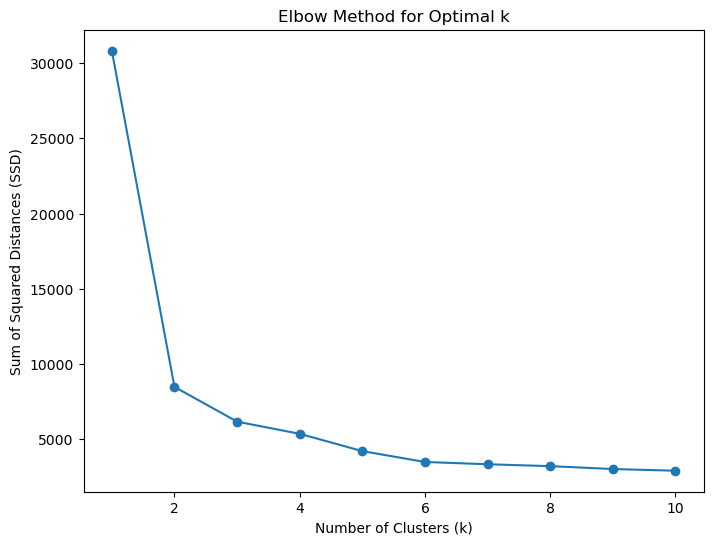

In [62]:
# Find the optimal number of clusters using the Elbow Method
kmeans.elbow_method(X_train_transformed)

**3.3 K-means Implementation**

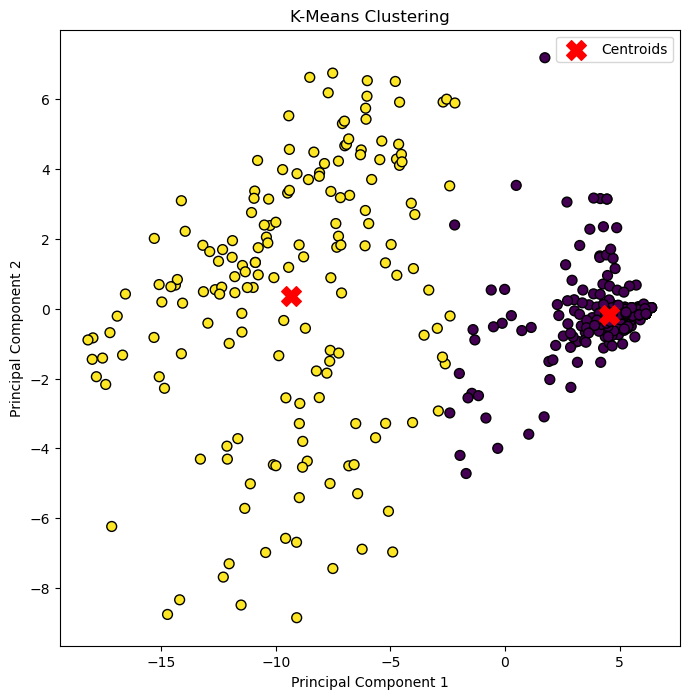

In [63]:
X_train_transformed = pca.transform(X_train)

# Create an instance of KMeansClustering
kmeans = KMeansClustering(k=2)
kmeans.fit(X_train_transformed)

# Plot clusters
kmeans.plot_clusters(X_train_transformed) 

The centroids chosen seem to sit around (-10, 0) for one cluster and (5, 0) for the other. The rightmost cluster seems to be more densely packed potentially meaning that it is a better cluster and more significanr than the other one.

**3.4 Performance of Clustering**

The silhouette score is a common metric of how well the clsuering model has clustered the data in terms of seperation of clusters and similarity within the clusters [6].

For each datapoint the average distance from itself to other datapoints within the same cluster is calculated to measure the density of a cluster. The same datapoints are then used to calcualte the average distance between itself and the nearest cluster measuring how far/well-seperated te clusters are.

This is combined with the silhouette score considering both with a larger average distance between clusters and lower average distance within a cluster leading to a more positive score. It is normalised by using the maximum of both intra-cluster distance and inter-cluster distance.

INSERT SILHOUETTE SCORE EQUATION

A score of -1 indiciates the clusters are assigned in the wrong way. A score of 0 suggests there may be overlapping clusters with seperation being the problem and 1 being seen with well-seperated clusters that are dense.

In [64]:
# Calculate and print silhouette score
silhouette = kmeans.silhouette_score(X_train_transformed)
print(f"Silhouette Score: {silhouette}") 

Silhouette Score: 0.6822766413614265


A score of 0.68 indicates a stronger seperation of clusters and density meaning the clusters identifies are significant with the principal components being useful in identifying the clusters in the data.

# References
----

[1] Taskesen, E. 2020. pca: A Python Package for Principal Component Analysis. [online] GitHub. Available at: https://github.com/erdogant/pca/ [Accessed 29 Dec. 2023].

[2] Garrahan JP, Gillman E, Mair JF. 2023. Machine Learning in Science Part 1 (PHYS4035) Lecture Notes.
‌

[3] Springer Series in Statistics 2002. Choosing a Subset of Principal Components or Variables. In: Principal Component Analysis. Springer, New York, NY. https://doi.org/10.1007/0-387-22440-8_6

[4] Burkov, A. (2023). The hundred-page machine learning book. Andriy Burkov. 

[5] Dangeti, P. (2017). Statistics for Machine Learning. Packt. 

[6] Bonaccorso, G. (2018). Machine learning algorithms: Popular algorithms for Data Science and Machine Learning. Packt. 